In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


import sys, os
sys.path.append(os.path.abspath('..'))

from gym_pk.agents import QAgent , BlackjackAgent, MonteCarloAgent, TD_0_Agent

In [3]:
# env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False)
# # env = gym.make("CliffWalking-v0")
# env = gym.make("Blackjack-v1")
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
# env.state_space
# env = gym.make("Taxi-v3", render_mode='rgb_array')
# env.reset()
# env.render()

## Test several agents on the same environment

In [53]:

from gym_pk.agents import QAgent , BlackjackAgent, MonteCarloAgent, TD_0_Agent, SarsaAgent, DynaQAgent

from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# comm_ag_params = dict(
# )

learning_rate = 0.7
n_episodes = 2000
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes )  # reduce the exploration over time
final_epsilon = 0.01
discount_factor = 0.8

# env = gym.make("Blackjack-v1", render_mode='ansi')
# env = gym.make("CliffWalking-v0", render_mode='ansi')
env = gym.make("Taxi-v3", render_mode='ansi')
# env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True, render_mode="rgb_array")
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agents = [

    (DynaQAgent, dict(
        dynaqplus = False,
        planning_steps=50,
        planning_seed=42,
        alpha=learning_rate,
        gamma=discount_factor,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,),      100 ),
    (DynaQAgent, dict(
        dynaqplus = True,
        planning_steps=50,
        planning_seed=42,
        alpha=learning_rate,
        gamma=discount_factor,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,),      100 ),
    # (QAgent, dict(
    #     alpha=learning_rate,
    #     gamma=discount_factor,
    #     initial_epsilon=start_epsilon,
    #     epsilon_decay=epsilon_decay,
    #     final_epsilon=final_epsilon,),  20),
    # (SarsaAgent, dict(
    #     expected_sarsa=True,
    #     alpha=learning_rate,
    #     gamma=discount_factor,
    #     initial_epsilon=start_epsilon,
    #     epsilon_decay=epsilon_decay,
    #     final_epsilon=final_epsilon,),  20),
    # (SarsaAgent, dict(
    #     expected_sarsa=False,
    #     alpha=learning_rate,
    #     gamma=discount_factor,
    #     initial_epsilon=start_epsilon,
    #     epsilon_decay=epsilon_decay,
    #     final_epsilon=final_epsilon,), 20),
    # (MonteCarloAgent, dict(
    #     gamma=1,
    #     initial_epsilon=start_epsilon,
    #     epsilon_decay=epsilon_decay,
    #     final_epsilon=final_epsilon), 50),
    # (BlackjackAgent, dict(    
    #     # action_space = env.action_space,
    #     alpha=learning_rate,
    #     gamma=discount_factor,
    #     learning_rate=learning_rate,
    #     initial_epsilon=start_epsilon,
    #     epsilon_decay=epsilon_decay,
    #     final_epsilon=final_epsilon,)),
        
    # (MonteCarloAgent, {**comm_ag_params, 'first_visit': True, 'exploring_starts_spec': {'q_value': 1000}}),
    # (MonteCarloAgent, {**comm_ag_params, 'first_visit': True, 'gamma': 0.1, 'exploring_starts_spec': {'q_value': 1000}}),
    # (MonteCarloAgent, {**comm_ag_params, 'first_visit': True,  'gamma': 0.2, 'exploring_starts_spec': {'q_value': 10000},  'epsilon_spec': {'epsilon': 0.2}}),
    # (TD_0_Agent, {**common_parameters})
]
run_stats = []
step_stats = []
agent_combos = []
for Agent, agent_params, a_episodes in agents:
    if a_episodes != -1: a_episodes = n_episodes
    # a_episodes = n_episodes
    # env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False)
    # env = gym.make("Taxi-v3")

    env = gym.make("Taxi-v3", render_mode='ansi')
    # env = gym.make("Blackjack-v1", render_mode='ansi')
    # env = gym.make("CliffWalking-v0", render_mode='ansi')
    # env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True, render_mode="rgb_array")
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    # print('agent_params', agent_params)

    # env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    agent = Agent(action_space=env.action_space, aparams=agent_params)
    agent_info = agent._info()
    agent_combos.append((env, agent))
    print(agent_info)
    for episode in tqdm(range(a_episodes)):
        obs, info = env.reset()
        agent.start_episode(obs)
        done = False
        # print('Startint new episode, obs from env:', obs)
        epi_return = 0
        # step
        # play one episode
        while not done:
            # if episode % 100 : print(env.render()) 

            action = agent.get_action(obs)
            # print('agent action =>', action)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            epi_return += reward
            # print('reward', reward)
            # print('obs: {}\taction: {}\tnext_obs: {}\treward: {}\t terminated: {}, truncated: {}, info: {}\n\t'.format(obs,action,next_obs, reward, terminated, truncated, info))
            step_stats.append((agent.algo,episode, obs, action,next_obs, reward, terminated, truncated, info, agent_info))
            # update the agent
            agent.update(obs, action, reward, done, next_obs)
            # print('episode history ->\n', agent.episode_history)
            # update if the environment is done and the current obs
            obs = next_obs
        
            agent.decay_epsilon()
        run_stats.append((agent.algo,episode,epi_return, agent_info))
    
    # print(env.unwrapped.render())
    

DynaQ: {'dynaqplus': False, 'planning_steps': 50, 'planning_seed': 42, 'alpha': 0.7, 'gamma': 0.8, 'initial_epsilon': 1, 'epsilon_decay': 0.0005, 'final_epsilon': 0.01}


100%|██████████| 2000/2000 [02:06<00:00, 15.84it/s]


DynaQ: {'dynaqplus': True, 'planning_steps': 50, 'planning_seed': 42, 'alpha': 0.7, 'gamma': 0.8, 'initial_epsilon': 1, 'epsilon_decay': 0.0005, 'final_epsilon': 0.01}


100%|██████████| 2000/2000 [01:02<00:00, 32.15it/s]


In [ ]:

print(agent_combos[0][0].unwrapped.render())

In [ ]:
rd = pd.DataFrame(step_stats).set_axis(['algo','episode','obs','action','next_obs', 'reward', 'terminated', 'truncated', 'info', 'agent_info'], axis=1)
perd = rd[['agent_info', 'episode','reward']].groupby(['agent_info', 'episode']).sum().reset_index()
perd['cum_return'] = perd.groupby(['agent_info']).reward.cumsum()
perd.set_index('episode').groupby('agent_info').cum_return.plot(x='episode', legend=True, title='Cumulative Episode Return')

In [ ]:
perd = rd[['agent_info', 'episode','reward']].groupby(['agent_info', 'episode']).sum().reset_index()
# perd['cum_return'] = perd.groupby(['agent_info']).reward.cumsum()
# perd
# perd.set_index('episode').groupby('agent_info').cum_return.plot(x='episode', legend=True, title='Cumulative Episode Return')
perd['rolling_return'] = perd.reset_index().set_index('episode').groupby('agent_info').reward.transform(lambda x: x.rolling(1000).mean())#.reset_index()#.rolling(1000).mean()
#.plot(x='episode',legend=True)
# perd
# perd.set_index('episode').groupby('agent_info').rolling_return.plot(x='episode', legend=True, title='Rolling Episode Return')

DynaQ: {'dynaqplus': False, 'planning_steps': 50, 'planning_seed': 42, 'alpha': 0.7, 'gamma': 0.8, 'initial_epsilon': 1, 'epsilon_decay': 0.0005, 'final_epsilon': 0.01}


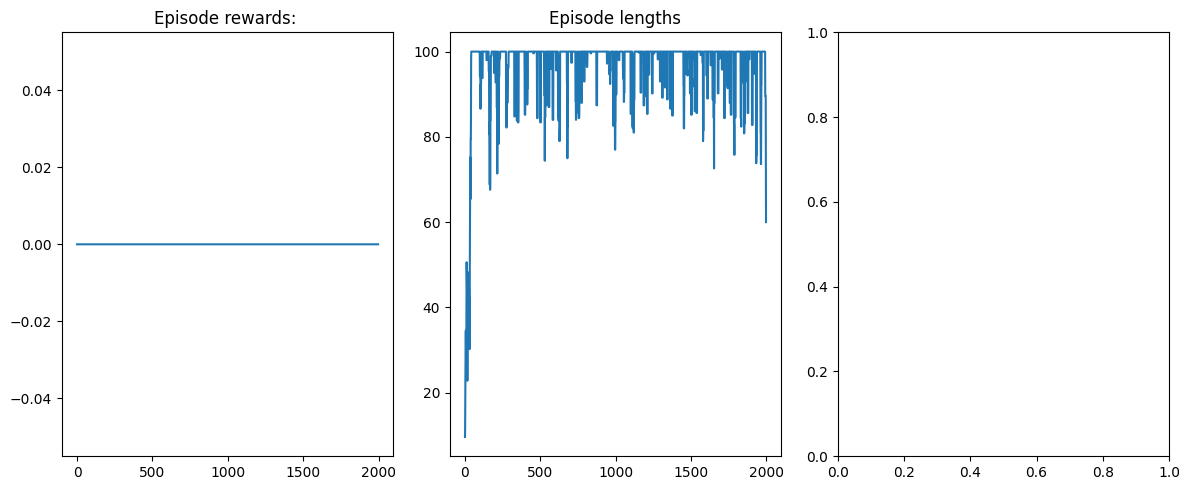

DynaQ: {'dynaqplus': True, 'planning_steps': 50, 'planning_seed': 42, 'alpha': 0.7, 'gamma': 0.8, 'initial_epsilon': 1, 'epsilon_decay': 0.0005, 'final_epsilon': 0.01}


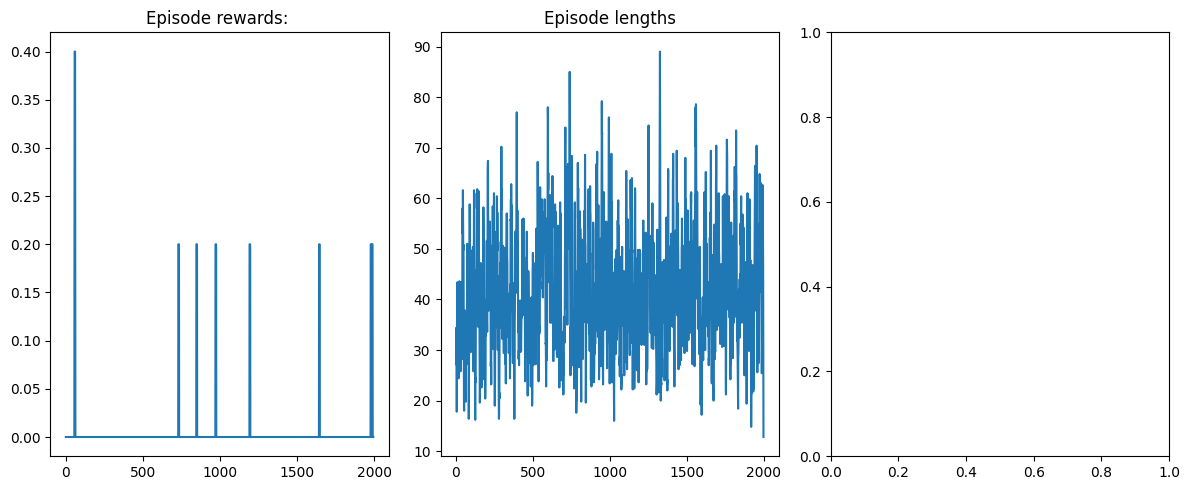

In [54]:
for env, agent in agent_combos:
    rolling_length = 5
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    
    axs[0].set_title("Episode rewards: " )
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[1].set_title("Episode lengths")
    length_moving_average = (
        np.convolve(
            np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    print(agent._info())
    # axs[2].set_title("Training Error")
    # training_error_moving_average = (
    #     np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    #     / rolling_length
    # )
    # axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.show()

In [52]:
print(agent_combos[0][0].render())

None


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/gymnasium/envs/toy_text/frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


DynaQ: {'dynaqplus': False, 'planning_steps': 50, 'planning_seed': 42, 'alpha': 0.7, 'gamma': 0.8, 'initial_epsilon': 1, 'epsilon_decay': 0.001, 'final_epsilon': 0.01}


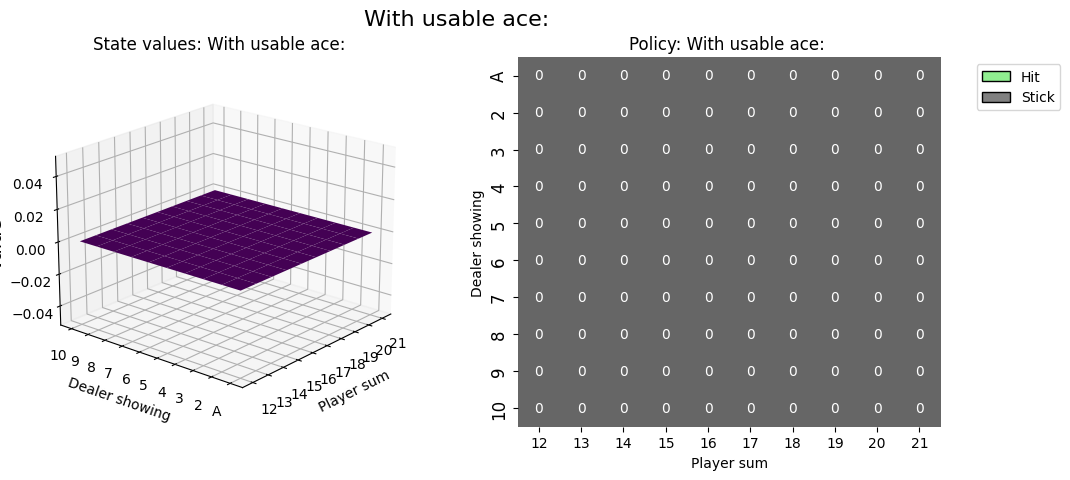

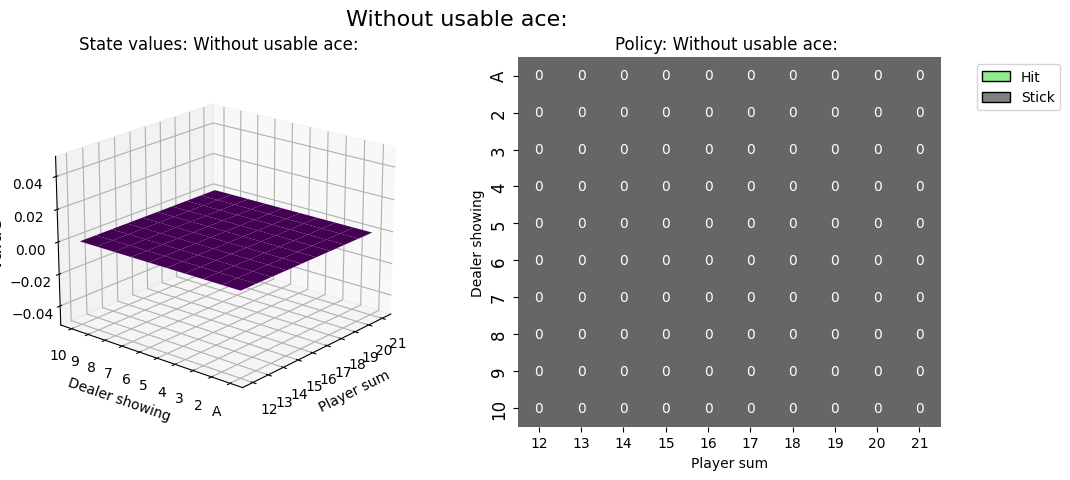

DynaQ: {'dynaqplus': True, 'planning_steps': 50, 'planning_seed': 42, 'alpha': 0.7, 'gamma': 0.8, 'initial_epsilon': 1, 'epsilon_decay': 0.001, 'final_epsilon': 0.01}


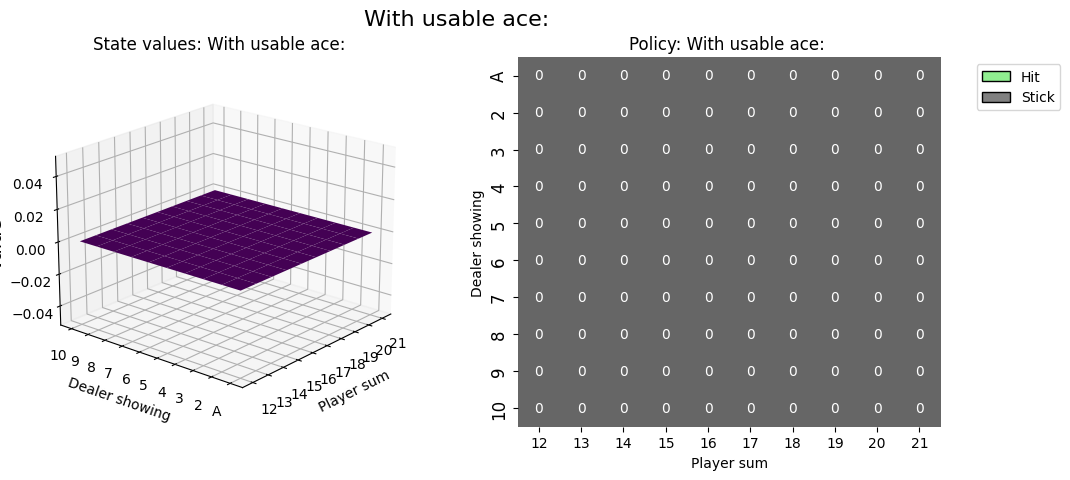

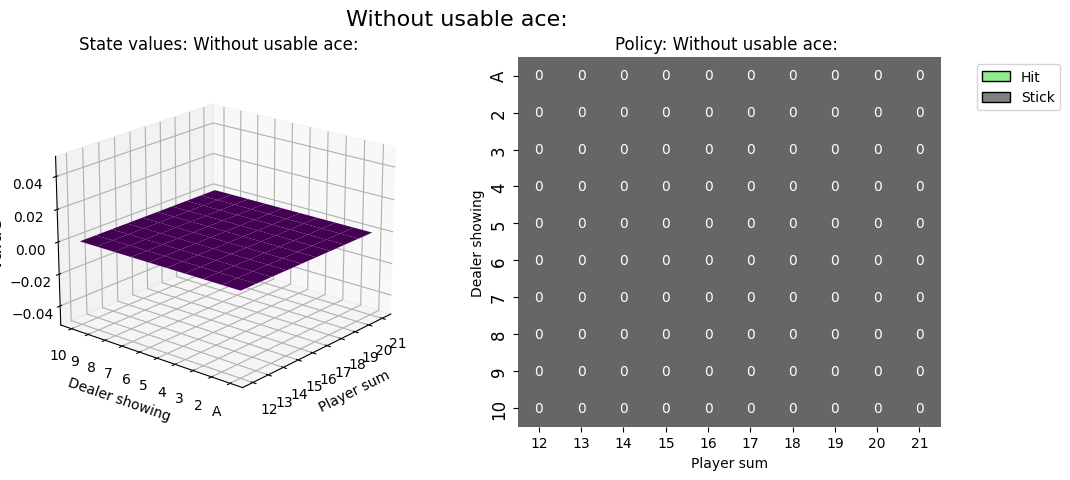

In [48]:
for env, agent in agent_combos:
    # state values & policy with usable ace (ace counts as 11)
    value_grid, policy_grid = create_grids(agent, usable_ace=True)
    fig1 = create_plots(value_grid, policy_grid, title="With usable ace: ")
    print( agent._info())
    plt.show()

    # state values & policy without usable ace (ace counts as 1)
    value_grid, policy_grid = create_grids(agent, usable_ace=False)
    fig2 = create_plots(value_grid, policy_grid, title="Without usable ace: " )
    plt.show()

In [ ]:

rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)

In [ ]:
run_stats

In [ ]:
run_unis[0][0].return_queue

## Test an agent on the Blackjack environment

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


import sys, os
sys.path.append(os.path.abspath('..'))

from gym_pk.agents import QAgent , BlackjackAgent, MonteCarloAgent, TD_0_Agent

#######################


learning_rate = 0.01
n_episodes = 20
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=True)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

comm_ag_params = dict(
    action_space = env.action_space,
    gamma = 1,
    initial_epsilon = start_epsilon,
    epsilon_decay= epsilon_decay,
    final_epsilon = final_epsilon
)
agent = MonteCarloAgent(**{**comm_ag_params})

# agent = BlackjackAgent(
#     action_space = env.action_space,
#     learning_rate=learning_rate,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
# )


for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    agent.start_episode()
    # play one episode
    while not done:
        action = agent.get_action(obs)
        # print('action', action)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        agent.decay_epsilon()

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

In [ ]:
pd.DataFrame(agent.q_values.items())

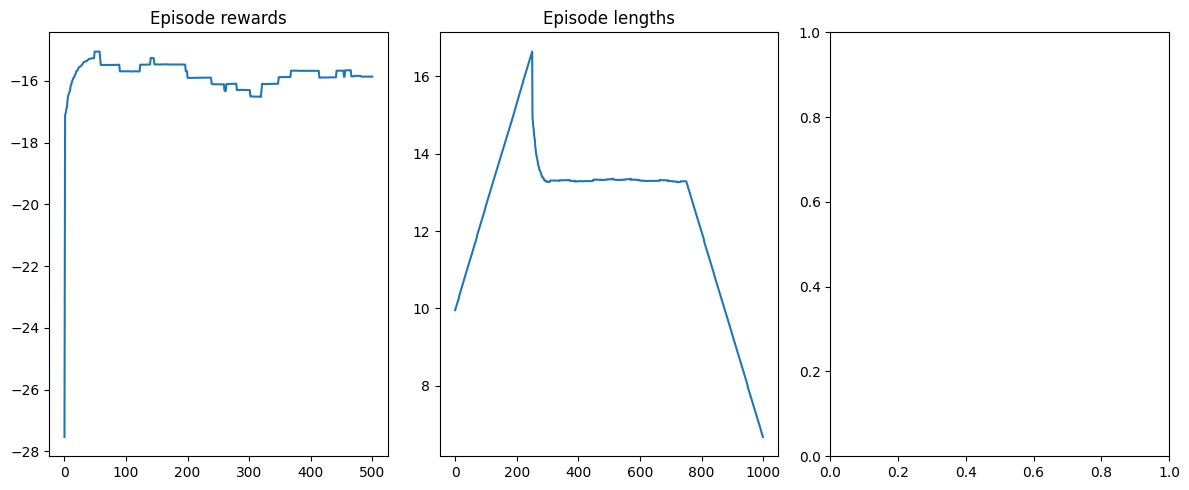

In [20]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
# axs[2].set_title("Training Error")
# training_error_moving_average = (
#     np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
#     / rolling_length
# )
# axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [43]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig
